In [2]:
#download face_recognition
%matplotlib inline
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 29 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=7a828f05952ec871390fa881a11c39c55025b8ff20b1509ac872bf3f1c858d28
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [3]:
# import library
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.cbook as cbook
import matplotlib.image as image
import matplotlib.pyplot as plt
import os
import re
import argparse
import math
import time
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy.random as npr
from PIL import Image
from numpy import asarray
from torchvision.io import read_image
import face_recognition

In [4]:
# define CNN
class HappyFaceClassifier_alex(nn.Module):
    def __init__(self):
        super(HappyFaceClassifier_alex, self).__init__()
        self.name = "HFC_alex"
        self.fc1 = nn.Linear(256*6*6, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)
        
    def forward(self, x):
        x = x.view(-1, 256*6*6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [5]:
#define autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 7)
        
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
  
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
#download weight for CNN
!gdown --id '1wn9D-aJDGtboO8eZFZHlxW4KS5njz_3j'

Downloading...
From: https://drive.google.com/uc?id=1wn9D-aJDGtboO8eZFZHlxW4KS5njz_3j
To: /content/model_HFC_alex_bs512_lr0.005_epoch8
100% 39.9M/39.9M [00:00<00:00, 96.0MB/s]


In [7]:
#download weight for Autoencoder
!gdown --id '1DNi6kKXQ9xfa_z4AmO1FnSTYYM2AEwKJ'

Downloading...
From: https://drive.google.com/uc?id=1DNi6kKXQ9xfa_z4AmO1FnSTYYM2AEwKJ
To: /content/model_weights.pth
100% 13.6M/13.6M [00:00<00:00, 63.7MB/s]


In [8]:
# extract human faces in an image as ROI using existing library
def Face_Extraction(image_path):
    # read the input image
    image = face_recognition.load_image_file(image_path)

    # find face locations
    face_locations = face_recognition.face_locations(image)
    
    # save extracted face image in dictionary 
    # {face_num: face_image_array}
    face_num = 1
    face_dict = {}
    for (top, right, bottom, left) in face_locations:
        face_dict[face_num] = (image[top:bottom, left:right], (top, right, bottom, left))
        print(image[top:bottom, left:right].shape)
        face_num += 1
    
    return face_dict

In [9]:
def Face_Classifier(image_array):
    # define image
    image = torch.tensor(np.transpose(image_array, (2, 1, 0)))
    # resize image to fit model (3x224x224)
    transform = transforms.Compose([transforms.Resize(224),
                                    transforms.Grayscale(3)])
    image = transform(image).unsqueeze(dim=0)
    
    # define trained models
    model = HappyFaceClassifier_alex()
    pretrained_model = torchvision.models.alexnet(pretrained=True)
    model_path = '/content/model_HFC_alex_bs512_lr0.005_epoch8'
    state = torch.load(model_path)
    model.load_state_dict(state)
    
    # feature extraction
    features = pretrained_model.features(image/255)
    # model prediction
    output = model(features)
    pred = (output > 0.0).squeeze().long()
    if pred == 1:
        print("This person is happy.")
        return True
    else:
        print("This person is not happy.")
        return False

In [10]:
def Happy_Face_Recognition(image_path):
    # display image
    image_input = Image.open(image_path)
    plt.imshow(np.asarray(image_input))
    plt.show()
    
    # extract faces in the image
    face_dict = Face_Extraction(image_path)

    nonhappy_face_dict = {}
    # loop over extracted faces
    for face_num in face_dict:
        face_image_array = face_dict[face_num][0]
        
        # show extracted faces
        plt.imshow(face_image_array)
        plt.show()
        
        # recognize happy facial expression
        if Face_Classifier(face_image_array) == False:
            nonhappy_face_dict[face_num] = (face_image_array, face_dict[face_num][1])
            
    return nonhappy_face_dict

In [11]:
def Transfer_Face(nonhappy_face_dict):
  #load mautoencoder model 
    model = Autoencoder()
    model.load_state_dict(torch.load('/content/model_weights.pth'))
    fake_face_dict = {}
    for face_num in nonhappy_face_dict:
        #resize image to 224*224
        face_image_array = nonhappy_face_dict[face_num][0]
        pic = Image.fromarray(face_image_array)
        pic = pic.resize((224, 224), Image.ANTIALIAS)
        pic.save('my1.jpg')
        face_image_array2= plt.imread('my1.jpg') 
        # transfer faces
        print(face_image_array2.shape)
        fake_image_array = np.transpose(np.asarray(model(torch.tensor(np.transpose(face_image_array2,[2,1,0])/255)[None,...].float()).cpu().detach()),[0,3,2,1])
        fake_image_array=fake_image_array[0]* 255
        fake_image_array= fake_image_array.astype(np.uint8)
        pic = Image.fromarray(fake_image_array)
        pic = pic.resize((face_image_array.shape[1], face_image_array.shape[0]), Image.ANTIALIAS)
        pic.save('my.jpg')
        fake_image_array= plt.imread('my.jpg')                                                                                 
        fake_face_dict[face_num] = (fake_image_array, nonhappy_face_dict[face_num][1])
        
    return fake_face_dict

In [12]:
def Replace_Face(fake_face_dict, image_path):
    # read the input image
    image = face_recognition.load_image_file(image_path)
    
    for face_num in fake_face_dict:
        face_image_array = fake_face_dict[face_num][0]
        
        # replace face images
        (top, right, bottom, left) = fake_face_dict[face_num][1]
        image[top:bottom, left:right] = face_image_array

    plt.imshow(image)
    plt.show()
    return Image.fromarray(image)

In [13]:
def Happy_Face_Recognition(image_path):
    # display image
    image_input = Image.open(image_path)
    plt.imshow(np.asarray(image_input))
    plt.show()
    
    # extract faces in the image
    face_dict = Face_Extraction(image_path)

    nonhappy_face_dict = {}
    # loop over extracted faces
    for face_num in face_dict:
        face_image_array = face_dict[face_num][0]
        
        # show extracted faces
        plt.imshow(face_image_array)
        plt.show()
        
        # recognize happy facial expression
        if Face_Classifier(face_image_array) == False:
            nonhappy_face_dict[face_num] = (face_image_array, face_dict[face_num][1])
            
    return nonhappy_face_dict

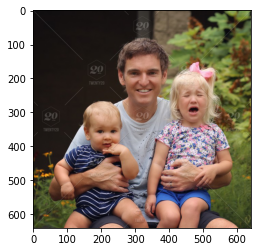

(129, 129, 3)
(89, 90, 3)
(90, 90, 3)


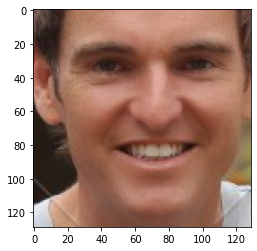

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

This person is happy.


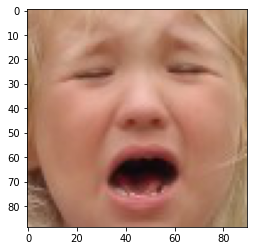

This person is not happy.


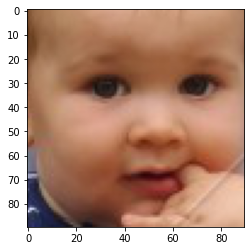

This person is not happy.
(224, 224, 3)
(224, 224, 3)


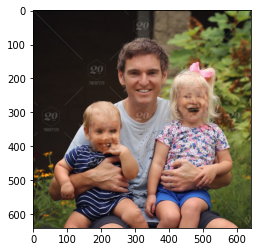

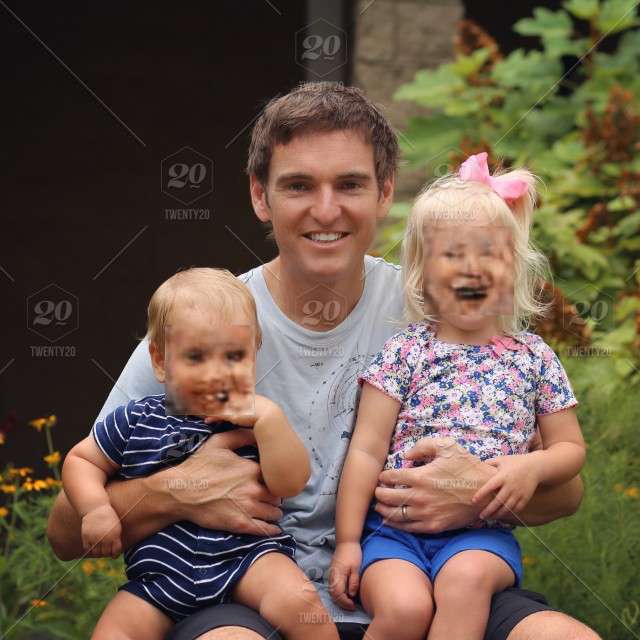

In [14]:
# Input: image directory
image_path = '/content/stock-photo-childhood-baby-boy-family-crying-tears-kids-fatherhood-father-and-child-crying-toddler-bf9e88e9-a5ab-440e-b633-620e9c7e3d5a.jpg'
# Apply happy face recognition
nonhappy_face_dict = Happy_Face_Recognition(image_path)
fake_face_dict = Transfer_Face(nonhappy_face_dict)
Replace_Face(fake_face_dict, image_path)